# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np


import matplotlib.pyplot as plt

import random
from collections import namedtuple, deque


from ddpg_agent import Agent


#from model import Network

import torch
import torch.nn.functional as F
import torch.optim as optim




Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
def ddpg(num_agents,n_episodes=2000, eps_start=1., eps_end=0.1, eps_decay=.95):
    
    scores = []                        # list containing scores from each episode
    scores_avg=[]
    scores_window = deque(maxlen=100)  # last 100 scores
    print_window=deque(maxlen=5)
    print_avg=[]
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        cnt=0
        env_info = env.reset(train_mode=True)[brain_name]

        state = env_info.vector_observations[:]
        state=np.array(state)
        score = np.zeros(num_agents)
        while True:        
            action=agent.act(state,i_episode,eps)        
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[:]      # get the next state
            reward = env_info.rewards[:]                   # get the reward
            done = env_info.local_done[:]                     # see if episode has finished                       
            agent.step(state, action, reward, next_state, done,i_episode, learn=True)            
            state=next_state        
            score += np.array(reward)           
            if np.any(done):
                break 
        scores_window.append(np.max(score))       # save most recent score
        scores.append(np.max(score))              # save most recent score
        print_window.append(np.max(score))        # save most recent score to get an average over 5 episodes
        scores_avg.append(np.mean(scores_window))
        print_avg.append(np.mean(print_window))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
     
        print('\rEpisode {}\tAverage Score: {:.3f}\tCurrent Score: {:.3f}'.format(i_episode, np.mean(scores_window), np.max(score)), end="")
        if i_episode % 1 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tCurrent Score: {:.3f}'.format(i_episode, np.mean(scores_window), np.max(score)))
        if np.mean(scores_window)>=.5 and i_episode>=100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_network_local.state_dict(), 'actor_model.pt')
            torch.save(agent.critic_network_local.state_dict(), 'critic_model.pt')
            
            break
    return scores,scores_avg,print_avg

agent = Agent(state_size=len(env_info.vector_observations[0]), action_size=brain.vector_action_space_size,n_agents=states.shape[0], seed=40)
scores, scores_avg,print_avg = ddpg(num_agents= states.shape[0])

Episode 1	Average Score: 0.000	Current Score: 0.000
Episode 2	Average Score: 0.000	Current Score: 0.000
Episode 3	Average Score: 0.000	Current Score: 0.000
Episode 4	Average Score: 0.000	Current Score: 0.000
Episode 5	Average Score: 0.000	Current Score: 0.000
Episode 6	Average Score: 0.017	Current Score: 0.100
Episode 7	Average Score: 0.014	Current Score: 0.000
Episode 8	Average Score: 0.013	Current Score: 0.000
Episode 9	Average Score: 0.011	Current Score: 0.000
Episode 10	Average Score: 0.010	Current Score: 0.000
Episode 11	Average Score: 0.009	Current Score: 0.000
Episode 12	Average Score: 0.008	Current Score: 0.000
Episode 13	Average Score: 0.008	Current Score: 0.000
Episode 14	Average Score: 0.007	Current Score: 0.000
Episode 15	Average Score: 0.007	Current Score: 0.000
Episode 16	Average Score: 0.006	Current Score: 0.000
Episode 17	Average Score: 0.006	Current Score: 0.000
Episode 18	Average Score: 0.006	Current Score: 0.000
Episode 19	Average Score: 0.005	Current Score: 0.000
Ep

Episode 156	Average Score: 0.001	Current Score: 0.000
Episode 157	Average Score: 0.001	Current Score: 0.000
Episode 158	Average Score: 0.001	Current Score: 0.000
Episode 159	Average Score: 0.001	Current Score: 0.000
Episode 160	Average Score: 0.001	Current Score: 0.000
Episode 161	Average Score: 0.001	Current Score: 0.000
Episode 162	Average Score: 0.001	Current Score: 0.000
Episode 163	Average Score: 0.001	Current Score: 0.000
Episode 164	Average Score: 0.001	Current Score: 0.000
Episode 165	Average Score: 0.001	Current Score: 0.000
Episode 166	Average Score: 0.001	Current Score: 0.000
Episode 167	Average Score: 0.001	Current Score: 0.000
Episode 168	Average Score: 0.001	Current Score: 0.000
Episode 169	Average Score: 0.001	Current Score: 0.000
Episode 170	Average Score: 0.001	Current Score: 0.000
Episode 171	Average Score: 0.001	Current Score: 0.000
Episode 172	Average Score: 0.001	Current Score: 0.000
Episode 173	Average Score: 0.001	Current Score: 0.000
Episode 174	Average Score: 0

Episode 309	Average Score: 0.009	Current Score: 0.000
Episode 310	Average Score: 0.009	Current Score: 0.000
Episode 311	Average Score: 0.009	Current Score: 0.000
Episode 312	Average Score: 0.009	Current Score: 0.000
Episode 313	Average Score: 0.009	Current Score: 0.000
Episode 314	Average Score: 0.009	Current Score: 0.000
Episode 315	Average Score: 0.009	Current Score: 0.000
Episode 316	Average Score: 0.009	Current Score: 0.000
Episode 317	Average Score: 0.009	Current Score: 0.000
Episode 318	Average Score: 0.009	Current Score: 0.000
Episode 319	Average Score: 0.009	Current Score: 0.000
Episode 320	Average Score: 0.009	Current Score: 0.000
Episode 321	Average Score: 0.009	Current Score: 0.000
Episode 322	Average Score: 0.009	Current Score: 0.000
Episode 323	Average Score: 0.009	Current Score: 0.000
Episode 324	Average Score: 0.009	Current Score: 0.000
Episode 325	Average Score: 0.009	Current Score: 0.000
Episode 326	Average Score: 0.009	Current Score: 0.000
Episode 327	Average Score: 0

Episode 462	Average Score: 0.071	Current Score: 0.100
Episode 463	Average Score: 0.072	Current Score: 0.100
Episode 464	Average Score: 0.071	Current Score: 0.090
Episode 465	Average Score: 0.071	Current Score: 0.100
Episode 466	Average Score: 0.072	Current Score: 0.090
Episode 467	Average Score: 0.072	Current Score: 0.100
Episode 468	Average Score: 0.073	Current Score: 0.100
Episode 469	Average Score: 0.074	Current Score: 0.090
Episode 470	Average Score: 0.075	Current Score: 0.090
Episode 471	Average Score: 0.076	Current Score: 0.090
Episode 472	Average Score: 0.076	Current Score: 0.100
Episode 473	Average Score: 0.076	Current Score: 0.100
Episode 474	Average Score: 0.076	Current Score: 0.090
Episode 475	Average Score: 0.076	Current Score: 0.100
Episode 476	Average Score: 0.077	Current Score: 0.200
Episode 477	Average Score: 0.079	Current Score: 0.200
Episode 478	Average Score: 0.080	Current Score: 0.100
Episode 479	Average Score: 0.081	Current Score: 0.100
Episode 480	Average Score: 0

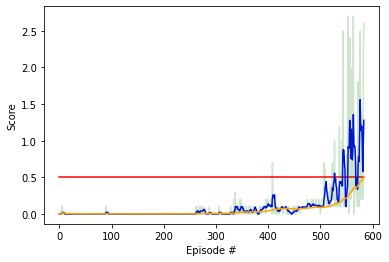

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),0.5*np.ones(len(scores)),c='red')

plt.plot(np.arange(len(scores)),print_avg,c='blue')
plt.plot(np.arange(len(scores)),scores,c='green',alpha=0.2)

plt.plot(np.arange(len(scores)),scores_avg,c='orange')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [7]:
env.close()